# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [9]:
# Load pickled data
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from sklearn.preprocessing import LabelBinarizer #to 'one-hot' encode the y labels
from sklearn.model_selection import train_test_split #to shuffle training data and split training and validation data
import tensorflow as tf
import time
from datetime import timedelta
import os #for saving/opening files e.g. saving tensorflow variables
import cv2 #for generating additional images (by jittering existing images)
import csv #to open the sign names csv file
from sklearn.metrics import confusion_matrix

In [10]:
# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [11]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_test.shape[1:-1]

# TODO: how many classes are in the dataset
n_classes = np.max(y_train) + 1 #as zero is a class type

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [12]:
is_fake_data_generated = False #Initially it's not generated
use_fake_data = True 
is_fake_data_concatenated = False #Initialy its not concatenated
is_features_normal = False #Initially the input features are not normalized
is_labels_encod = False #Initially there is no 'one-hot' encoding.
is_training_data_shuffled = False #Initially its not suffled.
is_test_data_shuffled = False #Initially its not suffled.
is_validation_data = False #Initially we don't have any validation data

standardize_image = False #to do standardized pre-processing (note: must choose either standardization or normalization but not both)
normalize_image = True #to do normalized preprocessing (note: must choose either standardization or normalization but not both)

In [13]:
### Data exploration visualization goes here.

#This is a function to plot any number of images
def plot_images(pltimages, true_labels, pred_labels=None):
    
    subplt_dim = math.ceil(math.sqrt(pltimages.shape[0]))
    
    # Create figure with subplt_dim x subplt_dim sub-plots.
    fig, axes = plt.subplots(subplt_dim, subplt_dim)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Plot image if i is less than image length.
        if i >= pltimages.shape[0]:
            continue
        ax.imshow(pltimages[i])
        
        # Show true and predicted classes.
        if pred_labels is None:
            xlabel = "True: {0}".format(true_labels[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_labels[i], pred_labels[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

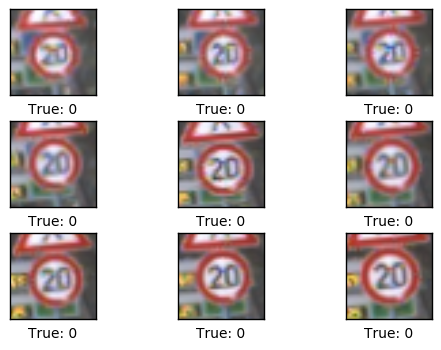

In [14]:
# Plot n images from the entire training set in sequence or in random
n_img = 9
n_img_array = range(0,n_img) #in sequence
#n_img_array = np.random.randint(0, high=n_train, size=n_img) #in random
plot_images(X_train[n_img_array], y_train[n_img_array])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
#Determine how many images are of each class in the training set
def num_of_each_classes(y_input_labels):
    label_list = np.zeros([43])
    for ii in y_input_labels:
        label_list[ii] += 1
    return label_list

In [16]:
#This function will take in an image and randomly perturb it (rotation, translations, and shear) to generate fake data
#The below function was taken from Vivek Yadav's Medium blogpost
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    #cv2.getRotationMatrix2D(center, angle, scale)
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [17]:
if not(is_fake_data_generated) and (use_fake_data):
    
    y_train_num_each_classes = num_of_each_classes(y_train) #array of the number of each class
    num_fake_data_per_class = 2500 - y_train_num_each_classes
    num_fake_data_array = np.ceil(num_fake_data_per_class/y_train_num_each_classes)
    num_fake_data_array = num_fake_data_array.astype(np.int32)
    num_fake_data_total = int(np.sum(num_fake_data_array * y_train_num_each_classes))

    print(y_train_num_each_classes)
    print(num_fake_data_array)
    print(num_fake_data_total)
    
    X_train_fake = np.zeros([num_fake_data_total, 32, 32, 3], dtype=np.uint8) #Make sure this is uint8. Default datatype messes up the colors
    y_train_fake = np.zeros([num_fake_data_total], dtype=np.uint8)
    fake_idx = 0
    for ii in range(X_train.shape[0]):
        for jj in range(num_fake_data_array[y_train[ii]]):
            X_train_fake[fake_idx] = transform_image(X_train[ii],10,8,5)
            y_train_fake[fake_idx] = y_train[ii]
            fake_idx += 1
    
    print(fake_idx)
    is_fake_data_generated = True
    
print("Fake Data Generated")

[  210.  2220.  2250.  1410.  1980.  1860.   420.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   630.   420.  1110.  1200.   210.
   360.   330.   390.   510.   270.  1500.   600.   240.   540.   270.
   450.   780.   240.   689.   420.  1200.   390.   210.  2070.   300.
   360.   240.   240.]
[11  1  1  1  1  1  5  1  1  1  1  1  1  1  3  3  5  2  2 11  6  7  6  4  9
  1  4 10  4  9  5  3 10  3  5  2  6 11  1  8  6 10 10]
91107
91107
Fake Data Generated


[  210.  2220.  2250.  1410.  1980.  1860.   420.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   630.   420.  1110.  1200.   210.
   360.   330.   390.   510.   270.  1500.   600.   240.   540.   270.
   450.   780.   240.   689.   420.  1200.   390.   210.  2070.   300.
   360.   240.   240.]
39209.0
[ 2310.  2220.  2250.  1410.  1980.  1860.  2100.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.  2340.  1890.  2100.  2220.  2400.  2310.
  2160.  2310.  2340.  2040.  2430.  1500.  2400.  2400.  2160.  2430.
  2250.  2340.  2400.  2067.  2100.  2400.  2340.  2310.  2070.  2400.
  2160.  2400.  2400.]
91107.0


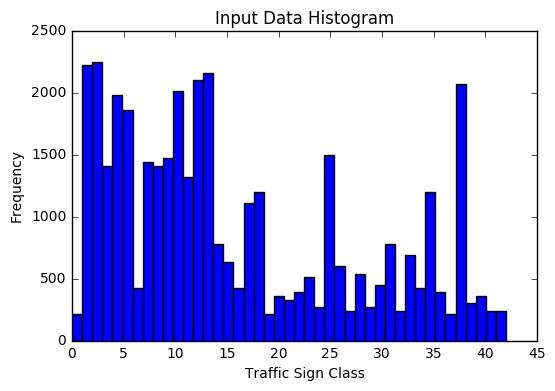

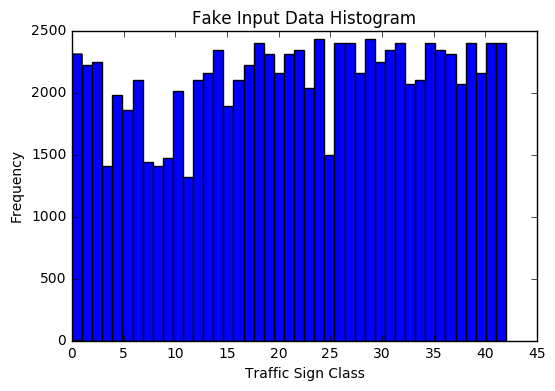

In [18]:
# Show histogram of different image classes
y_train_num_each_classes = num_of_each_classes(y_train)
print(y_train_num_each_classes)
print(np.sum(y_train_num_each_classes))
y_train_num_each_classes = num_of_each_classes(y_train_fake)
print(y_train_num_each_classes)
print(np.sum(y_train_num_each_classes))

#Plot a histogram of how many images are of each type
plt.hist(y_train, bins=43)
plt.title("Input Data Histogram")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Frequency")
plt.show()

#Plot a histogram of how many images are of each type
plt.hist(y_train_fake, bins=43)
plt.title("Fake Input Data Histogram")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Frequency")
plt.show()

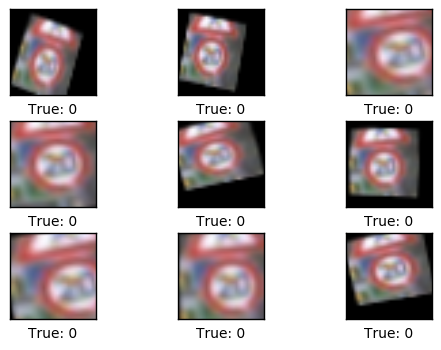

In [19]:
if (is_fake_data_generated):
    # Plot n images from the entire fake data set in sequence or in random
    n_img = 9
    n_img_array = range(0,n_img) #in sequence
    #n_img_array = np.random.randint(0, high=n_train, size=n_img) #in random
    plot_images(X_train_fake[n_img_array], y_train_fake[n_img_array])

In [20]:
if ((use_fake_data) and not(is_fake_data_concatenated)):
    X_train = np.concatenate((X_train, X_train_fake), axis=0)
    y_train = np.concatenate((y_train, y_train_fake), axis=0)
    is_fake_data_concatenated = True
        
print("Fake Data Concatenated to the Original Data")
print(X_train.shape)
print(y_train.shape)

Fake Data Concatenated to the Original Data
(130316, 32, 32, 3)
(130316,)


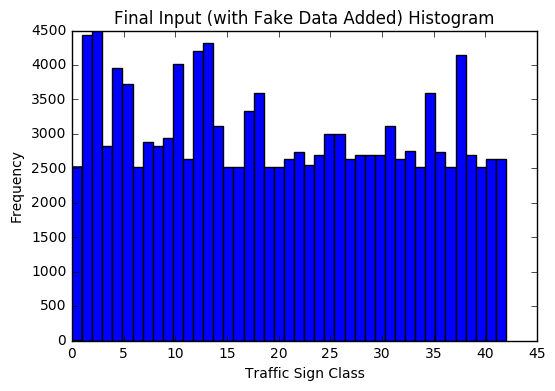

In [21]:
#Plot a histogram of how many images are of each type in the final training set
plt.hist(y_train, bins=43)
plt.title("Final Input (with Fake Data Added) Histogram")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Frequency")
plt.show()

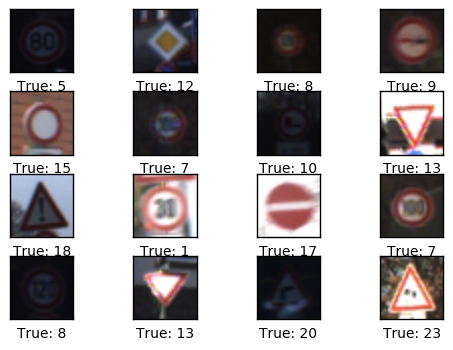

In [22]:
# Plot n images from the entire training set (incl. fake data if being used) in sequence or in random
n_img = 16
#n_img_array = range(0,n_img) #in sequence
n_img_array = np.random.randint(0, high=n_train, size=n_img) #in random
plot_images(X_train[n_img_array], y_train[n_img_array])

In [23]:
# Preprocess the data here.

In [24]:
# Standardize the features
def standardize_color(image_data, image_mean, image_std):
    """
    Standardize the image data with mean and standard deviation to [-1 to 1]
    :param image_data: The image data to be standardized
    :return: Standardized image data
    """
    # ToDo: Implement the feature standardization
    norm_img = (image_data - image_mean) / image_std
    
    return norm_img

# Normalize the features
def normalize_color(image_data):
    """
    Normalize the image data with max and min to -1 to 1
    :param image_data: The image data to be normalized
    :return: normalized image data
    """
    # ToDo: Implement the feature standardization
    norm_img = ((image_data)/255 - 0.5)*2 #so will be between -1 and +1
    
    return norm_img
    

In [25]:
if not is_features_normal:
    
    if standardize_image:
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_train = standardize_color(X_train, X_mean, X_std)
        X_test = standardize_color(X_test, X_mean, X_std)
    
        is_features_normal = True
    
    if normalize_image:
        X_train = normalize_color(X_train)
        X_test = normalize_color(X_test)
    
        is_features_normal = True
        
print('Features have been pre-processed')


#print(X_mean.shape) #to verify the mean is taken acorss all the examples
#print(X_std.shape) #to verify the standard dev is taken acorss all the examples
#for sanity check
print(np.max(X_test))
print(np.min(X_test))
print(np.mean(X_test))
print(np.std(X_test))

MemoryError: 

In [18]:
# #Randomly shuffle the training data. As right now it is ordered and so won't train well.
# #Amit's version without using sklearn
# if not is_training_data_shuffled:
#     n_train_array = np.arange(n_train)

#     #shuffle everything thoroughly by shuffling thrice.
#     np.random.shuffle(n_train_array); np.random.shuffle(n_train_array); np.random.shuffle(n_train_array)

#     X_train = X_train[n_train_array][:][:][:]
#     y_train = y_train[n_train_array][:][:][:]
    
#     is_training_data_shuffled = True

# print('Training Data Shuffled')

# #Create a validation dataset.
# if not is_validation_data:
#     n_val = 5000
#     X_val = X_train[0:n_val][:][:][:]
#     y_val = y_train[0:n_val][:][:][:]

#     X_train = X_train[n_val:][:][:][:]
#     y_train = y_train[n_val:][:][:][:]

#     n_train = X_train.shape[0] #adjustthe training data size.
    
#     is_validation_data = True
    
# print('Validation Data Created')

In [19]:
#Randomly shuffle the training data. As right now it is ordered and so won't train well.
#version using sklearn (it's better than Amit's version above in terms of really shuffling the data)

if (not is_training_data_shuffled) and (not is_validation_data) and (not is_test_data_shuffled):

    # Get randomized datasets for training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.05, #validation set is 5% of the training set
        random_state=1) #some seed to help with debugging
    
    # randomly shuffle the test datasets
    X_test, _, y_test, _ = train_test_split(
        X_test,
        y_test,
        test_size=0.0001, #Just to reshufffle the test set. So keep 99.99% of it
        random_state=1) #some seed to help with debugging
    
    is_training_data_shuffled = True
    is_test_data_shuffled = True
    is_validation_data = True
    
    
print('Training Data Shuffled')
print(X_train.shape[0])
print('Test Data Shuffled')
print(X_test.shape[0])
print('Validation Data Created')
print(X_val.shape[0])

Training Data Shuffled
123800
Test Data Shuffled
12628
Validation Data Created
6516


In [20]:
#We need to 'one-hot' encode the labels.
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding.
    encoder = LabelBinarizer()
    encoder.fit(np.array(y_train)) #No need to redo this for y_val and y_test as the one-hot encoded vector is same size for all of them
    y_train_onehot = encoder.transform(y_train)
    y_val_onehot = encoder.transform(y_val)
    y_test_onehot = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train_onehot = y_train_onehot.astype(np.float32)
    y_val_onehot = y_val_onehot.astype(np.float32)
    y_test_onehot = y_test_onehot.astype(np.float32)
    
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


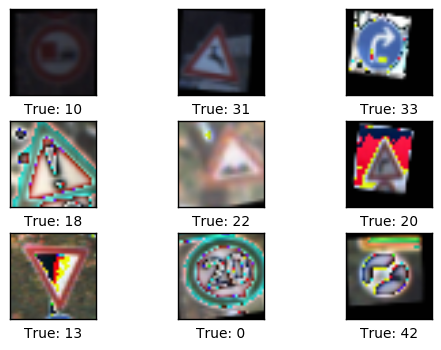

In [21]:
# Plot n images from the shuffled and resized training set (note images are normalized)
n_img = 9
n_img_array = range(0,n_img)
plot_images(X_train[n_img_array], y_train[n_img_array])

In [22]:
#for sanity check
print(X_train.dtype) #is float64
print(y_train.dtype) #is uint8

float64
uint8


In [23]:
assert is_fake_data_generated, 'You skipped the step to generate the fake data'
assert use_fake_data, 'Warning: You are not use the fake data for training!'
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'
assert is_training_data_shuffled, 'You skipped the step to randomly shuffle the training data'
assert is_validation_data, 'You skipped the step to generate the validation data'
assert is_test_data_shuffled, 'You skipped the step to randomly shuffle the test data'

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In general, feature standardization is more tolerant to outliers compared to feature normalization. In feature normalization, an outlier will really compress the rest of the data together (as we are dividing by the max-min value as opposed to the standard deviation as is the case with feature standardization). Moreover, and really a consequence of the previous advantage, is that standardization more effectively uncoveres similarities/covariance between different features -- as in standardization you maintain the relative distribution of the original data. 

Having said that, the advantage of normalization is that it limits the data between -1 and +1 whereas standardization limits the standard deviation to that range, and thus some data (and esp. outliers) will fall outside that range. While standardization is generally the preferred approach in many machine learning applications, with images, the pixels values need to fit a given range (e.g. 0 to 255). So normalization is the preferred approach. Moreover, with sigmoid-activation based neural networks, the input needs to be within a given range (e.g. -1 to 1) to prevent gradient saturation.

Moreover, when I experimented, with the given data set, normalization increased my validation accuracy by almost 1% compared to using standardization.

So here's the approach taken:
1. First feature normalization on the training and test set was performed
2. Then the data was randomly shuffled and a validation set was generated
3. There after the data labels are 'one-hot key' encoded to help with the training

In [24]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
As shown in the histogram above, the original training data is quite unevenly distributed -- which can potentially affect the test accuracy. To make it more evenly distributed, I generated additional training data. This also significantly increased my training data -- which is usually good.

In terms of the validation data, I randomly took 5% of the training data to generate the validation data. This could have been a larger number, but given the training set is so large, even with 5%, I still ended up with about 10,000 examples for the validation set.

Lastly, given the initially data were grouped together depending upon the class of the traffic sign, which is bad for stochastic gradient descent (as we take datasets in small batches), I randomly shuffled the training, validation, and test sets.

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [8]:
# Input image size in each dimension.
img_size = X_train.shape[1] #same for x and y dimensions.
num_img_channels = X_train.shape[3] #3 color channels for the input image and 1 for grayscale.
img_size_flat = img_size * img_size * num_img_channels #use for placeholder input. Tensorflow can't do placeholder for 4d tensor

# Number of classes, for the GTSRB dataset it's 43.
num_classes = y_test_onehot.shape[1]

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 32 of these filters.

# Fully-connected layer 1.
fc1_size = 1024             # Number of neurons in fully-connected layer1.

# Fully-connected layer 2.
fc2_size = 256             # Number of neurons in fully-connected layer2


# Fully-connected layer 3 (the output layer).
fc3_size = num_classes     # Number of neurons in fully-connected layer3/output layer.

keep_prob = tf.placeholder(tf.float32) #This is a global variable. Will be so defined explicitly inside any functions it will be used in

NameError: name 'X_train' is not defined

In [27]:
#Need to reshape the input images in to a 2D array for tensorflow placeholder as it can't accept a 4D tensor
# Note it is after input normalization
X_train_flat = X_train.reshape([-1, img_size_flat]) #-1 means it will automatically calculate it
X_val_flat = X_val.reshape([-1, img_size_flat]) #-1 means it will automatically calculate it
X_test_flat = X_test.reshape([-1, img_size_flat]) #-1 means it will automatically calculate it

In [28]:
#Helper functions
def new_weights(shape,sdev):
    weights = tf.truncated_normal(shape=shape, mean=0.0, stddev=sdev, dtype=tf.float32, seed=10)
    weights = tf.Variable(weights)
    return weights

def new_biases(length):
    biases = tf.constant(0, dtype=tf.float32, shape=[length])
    biases = tf.Variable(biases)
    return biases

In [29]:
def new_conv_layer(inpt,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True,
                   use_dropout = False):
    
    #shape of the filter weights.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    #using Xavier's method to initialize the weights. This is important.
    sdev = math.sqrt(2/(filter_size*filter_size*num_input_channels)) #*10 #0.05 #1
    #create new weigths.
    weights = new_weights(shape=shape, sdev=sdev)
    #Create new biases. One for each filter.
    biases = new_biases(length=num_filters)
    
    
    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=inpt, filter=weights, strides=[1,1,1,1], padding='SAME')
        # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer = tf.add(layer, biases)

    # Use pooling to down-sample the image resolution by 2X?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    
    #Use Dropout?
    if use_dropout:
        layer = tf.nn.dropout(layer, keep_prob)

    return layer, weights

In [30]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [31]:
def new_fc_layer(inpt,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,  # Use Rectified Linear Unit (ReLU)?
                 use_dropout=False): #Use dropout? (Amit added this code)

    # Create new weights and biases.
    #Using Xavier's method to initialize weights. This is important.
    sdev=math.sqrt(2/num_inputs) #*10 #0.05 #1
    weights = new_weights(shape=[num_inputs, num_outputs], sdev=sdev)
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.add(tf.matmul(inpt, weights), biases)

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    #Use Dropout?
    if use_dropout:
        layer = tf.nn.dropout(layer, keep_prob)
        
    return layer, weights

In [32]:
#Conv2d expects the input image to be a 4-dimensional tensor.
X_img_flat = tf.placeholder(tf.float32, shape=[None, img_size_flat])  #None means it can be of any size
X_image = tf.reshape(X_img_flat, shape=[-1, img_size, img_size, num_img_channels]) #-1 means it will automatically calculate
#X_image = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_img_channels]) #doesn't work as placeholder cant be more than 2D array
y_true_onehot = tf.placeholder(tf.float32, shape=[None, num_classes])

# fclayer2 = new_fc_layer(input=X_img_flat,
#                         num_inputs=img_size_flat,
#                         num_outputs=fc2_size,
#                         use_relu=True,
#                         use_dropout=False)
# logits = fclayer2


#cvlayer1 will be ? X 16 x 16 x 32
cvlayer1, cvweights1 = new_conv_layer(inpt=X_image,
                          num_input_channels = num_img_channels,
                          filter_size = filter_size1,
                          num_filters = num_filters1,
                          use_pooling = True,
                          use_dropout = True)

#cvlayer2 will be ? X 16 x 16 x 64
cvlayer2, cvweights2 = new_conv_layer(inpt=cvlayer1,
                          num_input_channels = num_filters1,
                          filter_size = filter_size2,
                          num_filters = num_filters2,
                          use_pooling = False,
                          use_dropout = True)


#But we first need to flatten cvlayer3 as the fully connected layer only accepts a 2 dimensional input.
# Then need to combine the outputs of CV1 and CV2
cvlayer1_flat, cvlayer1_numfeatures = flatten_layer(cvlayer1)
cvlayer2_flat, cvlayer2_numfeatures = flatten_layer(cvlayer2)
multipass_output = tf.concat(1, [cvlayer1_flat, cvlayer2_flat])
#num_features_multipass = multipass_output.get_shape()[1] #not sure why this doesn't work
#num_features_multipass = tf.cast(num_features_multipass, tf.int32) #not sure why this doesn't work
num_features_multipass = cvlayer1_numfeatures + cvlayer2_numfeatures #so using this as alternative approach

#fclayer1 will be ? X 1024
fclayer1, fcweights1 = new_fc_layer(inpt=multipass_output,
                        num_inputs=num_features_multipass,
                        num_outputs=fc1_size,
                        use_relu=True,
                        use_dropout=True)

#fclayer2 will be ? X 256
fclayer2, fcweights2 = new_fc_layer(inpt=fclayer1,
                        num_inputs=fc1_size,
                        num_outputs=fc2_size,
                        use_relu=True,
                        use_dropout=True)

#fclayer2 will be ? X 43 #Don't use Dropout for output layer. Also don't use ReLU for output layer
fclayer3, fcweights3 = new_fc_layer(inpt=fclayer2,
                        num_inputs=fc2_size,
                        num_outputs=fc3_size,
                        use_relu=False,
                        use_dropout=False)

logits = fclayer3


In [33]:
learning_rate = tf.constant(0.5e-3, dtype=tf.float32) #it performs better than 3e-3 in terms of accuracy
batch_size = 256 #256 #tf.constant(256) #, dtype=tf.float32) #256 #64
epochs = 15 #tf.constant(10) #, dtype=tf.float32)
lambda_reg = tf.constant(0.0001, dtype=tf.float32) #0.0005 #0.0

#keep_prob needs to be 1 when testing accuracy
#Limiting the size of the training size for measuring accuracy
train_feed_dict = {X_img_flat: X_train_flat[0:500], y_true_onehot: y_train_onehot[0:500], keep_prob: 1}
val_feed_dict = {X_img_flat: X_val_flat[0:500], y_true_onehot: y_val_onehot[0:500], keep_prob: 1}
test_feed_dict = {X_img_flat: X_test_flat[0:500], y_true_onehot: y_test_onehot[0:500], keep_prob: 1}

In [34]:
y_pred = tf.nn.softmax(logits) #will perform along the last dimension. y_pred is ? X 43
y_pred_cls = tf.arg_max(y_pred, dimension=1)
y_true_cls = tf.arg_max(y_true_onehot, dimension=1)
is_prediction_correct = tf.equal(y_pred_cls, y_true_cls) #boolean vector
accuracy = tf.reduce_mean(tf.cast(is_prediction_correct, tf.float32))
val_top5, indx_top5 = tf.nn.top_k(y_pred, k=5, sorted=True) #Top 5 predictions

#Cross_entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true_onehot) #will perform along the last dimension

loss_unreg = tf.reduce_mean(cross_entropy) #loss is a scalar
loss_reg = lambda_reg*(tf.nn.l2_loss(cvweights1) + tf.nn.l2_loss(cvweights2) + tf.nn.l2_loss(fcweights1) + tf.nn.l2_loss(fcweights2) + tf.nn.l2_loss(fcweights3))
loss = tf.add(loss_unreg, loss_reg)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
My final arichtecture is as follows:
1. Conv layer 1 with pooling, dropout, and ReLU activation with 32 filters
2. Conv layer 2 with dropout and ReLU activation with 64 filters (no pooling). Note that the output of both conv layers are feed to the first fully connected layer for better accuracy (ref. Lecun paper mentioned above)
3. Fully connected layer 1 with 1024 neurons with dropout and ReLU activation. The input to FC1 is fed from both, conv layers 1 and 2.
4. Fully connected layer 2 with 256 neurons with dropout and ReLU activation
5. Fully connected layer 3 (or the output layer) with 43 neurons with no dropout nor ReLU activation. Didn't use dropout on the output layer cause we always need to make predicitons about all the 43 different classes. And typically not using non-linearity (activation) in the output layer gives better performance.


In [39]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [40]:
#In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing 
#and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point
saver = tf.train.Saver()
save_dir = 'checkpoints/' #This is the directory used for saving and retrieving the data.

#Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
#This is the path for the files to be saved/restored
save_path = save_dir + 'best_validation'

In [4]:
init = tf.initialize_all_variables()

In [5]:
#Get the initial loss and accuracy for sanity check
with tf.Session() as session:
    session.run(init)
    acc_init, loss_init = session.run([accuracy, loss], feed_dict=val_feed_dict)
    print("Initial accuracy: {0:.1%}".format(acc_init)) #will be ~(1/43) = 2.3%
    print("Initial loss: {0:.5}".format(loss_init)) #will be ~-ln(1/43) = 3.7 (for unregularized softmax)

NameError: name 'accuracy' is not defined

In [43]:
with tf.Session() as session:
    
    global keep_prob #This is a global variable
    #No need to set save_path as global variable. Just define it before using it everytime as local variable.
    
    session.run(init) #no need to initialize always
    
    #Re-load all the variables that were saved to file during previous optimization.
    #This will initialize the weights to more optimum values -- faster training
    save_path = save_dir + 'best_validation' #save_path is local variable here
    #saver.restore(sess=session, save_path=save_path)
        
    batch_count = int(math.ceil(X_train_flat.shape[0]/batch_size))
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for epoch_i in range(epochs):
        
        for batch_i in range(batch_count):
            
            batch_start = batch_i * batch_size
            batch_end = batch_start + batch_size
            batch_images = X_train_flat[batch_start:batch_end]
            batch_labels = y_train_onehot[batch_start:batch_end]
            
            #Run the optimizer and get the loss
            _, l = session.run([optimizer, loss], feed_dict={X_img_flat: batch_images, y_true_onehot: batch_labels, keep_prob: 0.5})
            
        
        #print status every epoch
        acc_train = session.run(accuracy, feed_dict=train_feed_dict)
        acc_val = session.run(accuracy, feed_dict=val_feed_dict)
        acc = session.run(accuracy, feed_dict=test_feed_dict)
        # Message for printing.
        msg = "Epoch {0} => \t Training Accuracy: {1:>6.1%}"
        print(msg.format(epoch_i + 1, acc_train))
        msg = "Epoch {0} => \t Validation Accuracy: {1:>6.1%}"
        print(msg.format(epoch_i + 1, acc_val))
        msg = "Epoch {0} => \t Test Accuracy: {1:>6.1%}\n"
        print(msg.format(epoch_i + 1, acc))

    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Save all variables of the TensorFlow graph to file.
    save_path = save_dir + 'best_validation' #save_path is local variable here
    saver.save(sess=session, save_path=save_path)
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Epoch 1 => 	 Training Accuracy:  59.4%
Epoch 1 => 	 Validation Accuracy:  61.2%
Epoch 1 => 	 Test Accuracy:  68.6%

Epoch 2 => 	 Training Accuracy:  77.8%
Epoch 2 => 	 Validation Accuracy:  78.2%
Epoch 2 => 	 Test Accuracy:  81.6%

Epoch 3 => 	 Training Accuracy:  84.8%
Epoch 3 => 	 Validation Accuracy:  85.0%
Epoch 3 => 	 Test Accuracy:  87.2%

Epoch 4 => 	 Training Accuracy:  89.8%
Epoch 4 => 	 Validation Accuracy:  90.0%
Epoch 4 => 	 Test Accuracy:  89.2%

Epoch 5 => 	 Training Accuracy:  91.2%
Epoch 5 => 	 Validation Accuracy:  89.6%
Epoch 5 => 	 Test Accuracy:  89.0%

Epoch 6 => 	 Training Accuracy:  93.4%
Epoch 6 => 	 Validation Accuracy:  92.4%
Epoch 6 => 	 Test Accuracy:  89.4%

Epoch 7 => 	 Training Accuracy:  96.0%
Epoch 7 => 	 Validation Accuracy:  94.2%
Epoch 7 => 	 Test Accuracy:  90.2%

Epoch 8 => 	 Training Accuracy:  95.8%
Epoch 8 => 	 Validation Accuracy:  94.4%
Epoch 8 => 	 Test Accuracy:  91.0%

Epoch 9 => 	 Training Accuracy:  96.8%
Epoch 9 => 	 Validation Accuracy:

In [44]:
print("Final run's training loss: {0:.5}".format(l))

Final run's training loss: 0.53931


In [3]:
with tf.Session() as session:
    session.run(init)
    save_path = save_dir + 'best_validation' #save_path is local variable here
    saver.restore(sess=session, save_path=save_path)    
    train_feed_dict = {X_img_flat: X_train_flat[0:1000], y_true_onehot: y_train_onehot[0:1000], keep_prob: 1}
    acc = session.run(accuracy, feed_dict=train_feed_dict)
    print("Final Training accuracy: {0:.2%}".format(acc))
    

NameError: name 'init' is not defined

In [46]:
def plot_confusion_matrix(cls_pred, cls_true):

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # cls_true is an array of the actual (ground truth) class-number for
    # all images in the test-set.
    
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
#     tick_marks = np.arange(n_classes)
#     plt.xticks(tick_marks, range(n_classes))
#     plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [47]:
with tf.Session() as session:
    session.run(init)
    save_path = save_dir + 'best_validation' #save_path is local variable here
    saver.restore(sess=session, save_path=save_path)  
    
    acc = np.zeros(6)
    for i in range(6):
        start = 2000 * i
        stop = start + 2000
        test_feed_dict = {X_img_flat: X_test_flat[start:stop], y_true_onehot: y_test_onehot[start:stop], keep_prob: 1}
        acc[i], ytest_pred_cls, ytest_true_cls = session.run([accuracy, y_pred_cls, y_true_cls], feed_dict=test_feed_dict)
        print("Test accuracy {0}: {1:>6.1%}".format(i+1, acc[i]))
    
    print("Mean Test accuracy: {0:.1%}".format(np.mean(acc)))

Test accuracy 1:  92.5%
Test accuracy 2:  92.3%
Test accuracy 3:  92.7%
Test accuracy 4:  93.4%
Test accuracy 5:  91.8%
Test accuracy 6:  92.5%
Mean Test accuracy: 92.5%


[[  6   6   0 ...,   0   0   0]
 [  0 102   4 ...,   0   0   0]
 [  0   9 111 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  17   0   0]
 [  0   0   0 ...,   0   5   0]
 [  0   0   0 ...,   0   0   9]]


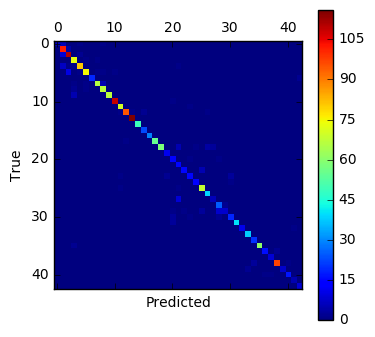

In [48]:
#Plot of a confusion matrix of the results from the last batch of test data above
#For each true class, it shows which are the different predicitons the model is making

plot_confusion_matrix(ytest_pred_cls, ytest_true_cls)

In [49]:
def unstandardize_color(norm_image, image_mean, image_std):
    """
    Un-standardize the image data with mean and standard deviation
    :param norm_image: The image data to be un-standardized
    :return: Un-standardized image data
    """
    # ToDo: Implement feature un-normalization (to restore the image to its original form)
    un_norm_image = (norm_image * image_std) + image_mean #it is float32
    un_norm_image = un_norm_image.astype(np.uint8) #need to cast to uint8 otherwise the image looks messed-up
    
    return un_norm_image

def unnormalize_color(norm_image):
    """
    Un-normalize the image data
    :param norm_image: The image data to be un-normalized
    :return: Un-normalize image data
    """
    un_norm_image = (norm_image/2+0.5)*255 #it is float32
    un_norm_image = un_norm_image.astype(np.uint8) #need to cast to uint8 otherwise the image looks messed-up
    return un_norm_image
    

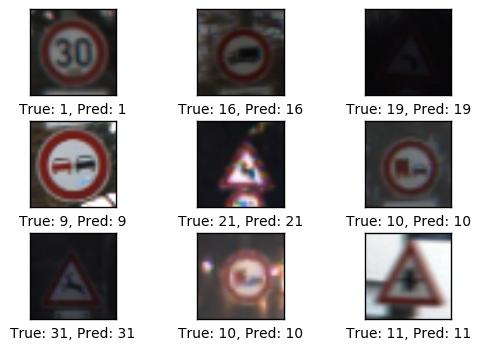

In [50]:
# Plot n images from the shuffled test test to check the accuracy of the predictions
n_img = 9
n_img_array = range(0,n_img) #in sequence
#n_img_array = np.random.randint(0, high=n_test, size=n_img) #in random

with tf.Session() as session:
    session.run(init)
    save_path = save_dir + 'best_validation' #save_path is local variable here
    saver.restore(sess=session, save_path=save_path)  
    
    test_feed_dict = {X_img_flat: X_test_flat[n_img_array], y_true_onehot: y_test_onehot[n_img_array], keep_prob: 1}
    y_pred_test, y_true_test = session.run([y_pred_cls, y_true_cls], feed_dict=test_feed_dict)

if standardize_image:
    X_test_unnorm = unstandardize_color(X_test, X_mean, X_std)

if normalize_image:
    X_test_unnorm = unnormalize_color(X_test)
    
plot_images(X_test_unnorm[n_img_array], y_true_test, y_pred_test)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I trained my model using the Adam optimizer as it adaptively adjusts the learning rate to allow for faster convergence and good accuracy. Moreover, the Adam optimizer uses momentum update to update the weights and biases so as to mitigate any noise in the gradients of a given batch from significantly affecting (or throwing off) the training direction. In a nutshell, Adam optimizer is RMSProp with momentum update, so the best optimizer we currently have.

I am using a batch size of 256, 15 epochs, dopout of 0.5 (during training) and lambda (L2 regularization) of 0.0001. Given these are all hyperparameters, to arrive at these values, I initially started off with some rule of thumb values for these parameters (or from the lecture notes) and then I adjusted them in a coarse manner (larger steps) to see if it is making significant difference, and when it did, and I then changed those parameters in finer steps.

For the regularization parameter, in addition to observing improvements in the validation accuracy, I was also looking at the difference between training and validation/test accuracies, as a larger difference betwen them suggests strong overfitting.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I started off with the ConvNet architecture used in Magnus Pedersen's tensorflow tutorials and then improved upon it based on the Udacity lectures and well as the LeCun paper referenced above. The Lecun paepr was an intersting read as it helped me learn about combining the output of different conv layers before feeding to the first fully connected layer for better accuracy.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [51]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [52]:
# Read the CSV file of sign_names
sign_names_files = 'signnames.csv'
class_ID = []
sign_name = []
with open(sign_names_files) as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        class_ID.append(row['ClassId'])
        sign_name.append(row['SignName'])
        print(row['ClassId'], row['SignName'])

0 Speed limit (20km/h)
1 Speed limit (30km/h)
2 Speed limit (50km/h)
3 Speed limit (60km/h)
4 Speed limit (70km/h)
5 Speed limit (80km/h)
6 End of speed limit (80km/h)
7 Speed limit (100km/h)
8 Speed limit (120km/h)
9 No passing
10 No passing for vechiles over 3.5 metric tons
11 Right-of-way at the next intersection
12 Priority road
13 Yield
14 Stop
15 No vechiles
16 Vechiles over 3.5 metric tons prohibited
17 No entry
18 General caution
19 Dangerous curve to the left
20 Dangerous curve to the right
21 Double curve
22 Bumpy road
23 Slippery road
24 Road narrows on the right
25 Road work
26 Traffic signals
27 Pedestrians
28 Children crossing
29 Bicycles crossing
30 Beware of ice/snow
31 Wild animals crossing
32 End of all speed and passing limits
33 Turn right ahead
34 Turn left ahead
35 Ahead only
36 Go straight or right
37 Go straight or left
38 Keep right
39 Keep left
40 Roundabout mandatory
41 End of no passing
42 End of no passing by vechiles over 3.5 metric tons


In [53]:
# This is only needed if I am trying to automatically determine the accuracy of the model's prediction on the test images
def one_hot_encode(true_label_class):
    one_hot_vec = np.zeros(43)
    one_hot_vec[true_label_class] = 1
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    one_hot_vec = one_hot_vec.astype(np.float32)
    return one_hot_vec

In [54]:
# outline
# 1. load the images
# 2. plot the images
# 3. re-size the images
# 4. pre-process the images (input normalization)
# 5. Feed image to the neural network for inference

def classify_image(img):    
    #plt.imshow(img)
    new_dim = (32,32)
    img_resized = cv2.resize(img, new_dim, interpolation=cv2.INTER_AREA)
    # X_mean and X_std are the mean and standard deviations of the entire training set
    plt.imshow(img_resized)
    plt.show()
    
    if standardize_image:
        img_normalized = standardize_color(img_resized, X_mean, X_std)
    if normalize_image:
        img_normalized = normalize_color(img_resized)
        
    img_norm_flat = img_normalized.reshape(-1, img_size_flat)
    
    with tf.Session() as session:
        session.run(init)
        save_path = save_dir + 'best_validation' #save_path is local variable here
        saver.restore(sess=session, save_path=save_path)  

        #we don't need to provide y_train_oneshot if we don't want to know the accuracy
        prediction = session.run(y_pred_cls, feed_dict={X_img_flat: img_norm_flat, keep_prob: 1})
        img_5, img_id_5 = session.run([val_top5, indx_top5], feed_dict={X_img_flat: img_norm_flat, keep_prob: 1})

        #print(img_id_5)
        #print(img_5)
        #print(prediction) #The prediction should be 14 for stop sign. Instead it predicts 12
        pred_desc = sign_name[prediction]
        return prediction, pred_desc, img_5, img_id_5

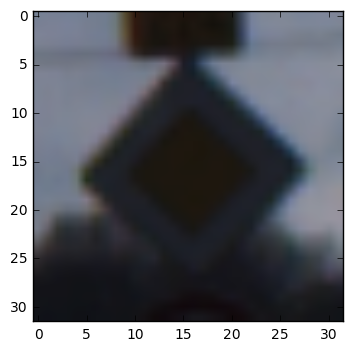

Test image named 12 is predicted to be: 12 (Priority road)
The top 5 predictions are:
12 (Priority road) with probability of 100.0%
26 (Traffic signals) with probability of 0.0%
42 (End of no passing by vechiles over 3.5 metric tons) with probability of 0.0%
17 (No entry) with probability of 0.0%
30 (Beware of ice/snow) with probability of 0.0%


C:\Users\amit_p\AppData\Local\Continuum\Anaconda3\envs\AmitSDCND\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [55]:
#To test specific class of images from the test data
img_cls_test = 12
test_image_id = (y_test == img_cls_test)
test_image_id = np.where(test_image_id)
test_image_id = test_image_id[0][200]
test_image = X_test_unnorm[test_image_id] #using the un-normalized test set

prediction, description, top5_prob, top5_ID = classify_image(test_image)
print('Test image named {0} is predicted to be: {1} ({2})'.format(img_cls_test, prediction[0], description))
print('The top 5 predictions are:')
for id5, prob5 in zip(top5_ID[0], top5_prob[0]):
    #print(id5)
    print('{0} ({2}) with probability of {1:.1%}'.format(id5,prob5,sign_name[id5]))
        

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Please see below for the results of five test images taken off the web. In terms of the qualities in the image that can make classification difficult, one thing is that many traffic signs in the US are different from the German traffic signs which the model is trained on, so this will be one difficulty. Another difficulty I have noticed is because the model is trained using a 32x32 pixels colored image, and since most off the web images I could find has over 300 x 300 pixels, this meant I had to resize them image to 32x32 pixels first -- thereby making the image blurry. And this caused difficulty in classify the images even though the test accuracy is 92%. I somewhat addressed this by generating additional training data by randomly jittering (rotating, translating, or skewing the image). Given more time, another thing to do is generate fake data with randomly varying brightness and contrast to further improve real images' accuracy.

In summary, because of the above mentioned reasons, even though the validation accuracy is 96.5% and test accuracy is 92.5%, the accuracy on the below five test images is merely 80%.

Please note that in order to resize the image, I decided against cropping the image because it won't generalize very well with any image as the traffic sign could be anywhere in the image.



In [56]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

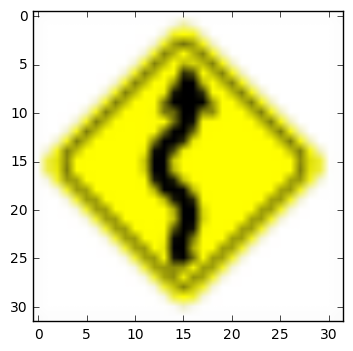

C:\Users\amit_p\AppData\Local\Continuum\Anaconda3\envs\AmitSDCND\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Test image named curvy_road.jpg is predicted to be: 12 (Priority road)
The top 5 predictions are:
12 (Priority road) with probability of 100.0%
26 (Traffic signals) with probability of 0.0%
42 (End of no passing by vechiles over 3.5 metric tons) with probability of 0.0%
13 (Yield) with probability of 0.0%
17 (No entry) with probability of 0.0%


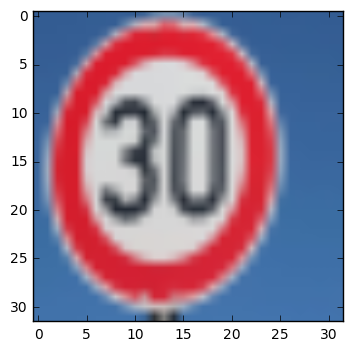

Test image named speed_30.jpg is predicted to be: 1 (Speed limit (30km/h))
The top 5 predictions are:
1 (Speed limit (30km/h)) with probability of 79.7%
0 (Speed limit (20km/h)) with probability of 16.5%
2 (Speed limit (50km/h)) with probability of 2.7%
4 (Speed limit (70km/h)) with probability of 1.0%
5 (Speed limit (80km/h)) with probability of 0.0%


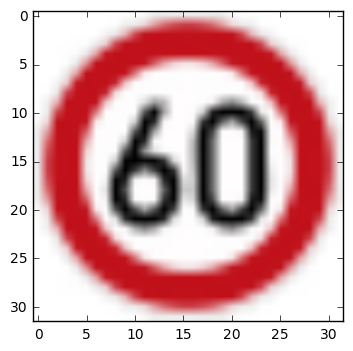

Test image named speed_60_2.jpg is predicted to be: 3 (Speed limit (60km/h))
The top 5 predictions are:
3 (Speed limit (60km/h)) with probability of 90.5%
0 (Speed limit (20km/h)) with probability of 6.6%
1 (Speed limit (30km/h)) with probability of 1.6%
2 (Speed limit (50km/h)) with probability of 1.3%
5 (Speed limit (80km/h)) with probability of 0.1%


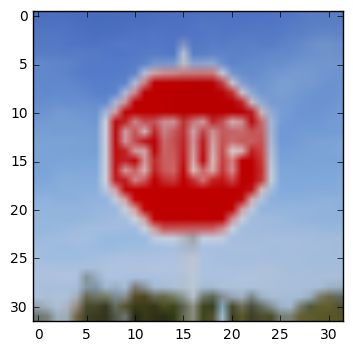

Test image named stopsign.jpg is predicted to be: 14 (Stop)
The top 5 predictions are:
14 (Stop) with probability of 100.0%
17 (No entry) with probability of 0.0%
12 (Priority road) with probability of 0.0%
10 (No passing for vechiles over 3.5 metric tons) with probability of 0.0%
13 (Yield) with probability of 0.0%


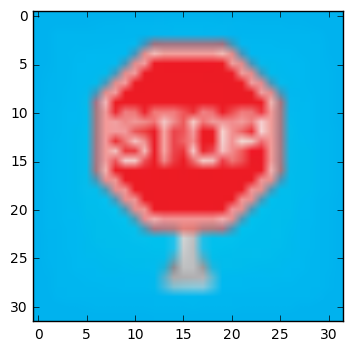

Test image named stopsign2.jpg is predicted to be: 14 (Stop)
The top 5 predictions are:
14 (Stop) with probability of 98.8%
17 (No entry) with probability of 1.2%
12 (Priority road) with probability of 0.0%
10 (No passing for vechiles over 3.5 metric tons) with probability of 0.0%
13 (Yield) with probability of 0.0%


In [57]:
test_images = os.listdir('test_traffic_signs/')

for idx,val in enumerate(test_images):
    #reading images
    test_image = mpimg.imread('test_traffic_signs/' + test_images[idx])    
    prediction, description, top5_prob, top5_ID = classify_image(test_image)
    print('Test image named {0} is predicted to be: {1} ({2})'.format(test_images[idx], prediction[0], description))
    print('The top 5 predictions are:')
    for id5, prob5 in zip(top5_ID[0], top5_prob[0]):
        #print(id5)
        print('{0} ({2}) with probability of {1:.1%}'.format(id5,prob5,sign_name[id5]))


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No the model performs much better on the test data than the images I downloaded from the web because of the two reasons I mentioned in question 7 above.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Please see above

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
The confusion matrix above shows a good overview of which images the model is having hard time predicting.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
The basic interface to test on newly acquired images is as follows:
1. Save all the test images (jpeg format only) in a directory named 'test_traffic_signs'
2. The above code will run through each image in this dircetory
3. Every image will be resized to 32x32 pixels
4. Then each image will be normalized using the mean and standard deviation values from the training set (upon which the model was trained)
5. Thereafter the normalized image is feed to the ConvNet for prediction. And it displays the class of the prediction as well as it's decription.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.